In [6]:
import alborexdata
import alborexpaths
import netCDF4
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
import cmocean
from alborexpaths import coordinates1, coordinates2
from importlib import reload
import urllib.request

importing configuration from alborexpaths


In [2]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [3]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

In [4]:
makeFigs, makeFigsLeaflet = 1, 0

Create a logger

In [8]:
logger = alborexdata.configure_logging("./logs/alborexFigure2.log")

Create a list of netCDF files containing SST

In [9]:
for sstfile, sstremote in zip(alborexpaths.sstfiles, alborexpaths.sstremotefiles):
    if not(os.path.exists(sstfile)):
        logger.info("Downloading data file {}".format(os.path.basename(sstfile)))
        urllib.request.urlretrieve(sstremote, sstfile)
    else:
        logger.info("SST file {} already downloaded".format(os.path.basename(sstfile)))

2019-01-11 22:46:10,445 - alborex_logger - INFO - SST file A2014145125000.L2_LAC_SST.nc already downloaded
2019-01-11 22:46:10,445 - alborex_logger - INFO - SST file A2014145125000.L2_LAC_SST.nc already downloaded
2019-01-11 22:46:10,456 - alborex_logger - INFO - SST file A2014150020500.L2_LAC_SST.nc already downloaded
2019-01-11 22:46:10,456 - alborex_logger - INFO - SST file A2014150020500.L2_LAC_SST.nc already downloaded


In [10]:
cmap = plt.cm.RdYlBu_r

# Data reading and plotting
## Coastline

In [11]:
loncoast, latcoast = alborexdata.read_lonlat_coast(alborexpaths.coastfile)

Create the projection (only once)

In [12]:
m = Basemap(projection='merc', llcrnrlon=coordinates1[0], llcrnrlat=coordinates1[2],
            urcrnrlon=coordinates1[1], urcrnrlat=coordinates1[3],
            lat_ts=0.5 * (coordinates1[2] + coordinates1[3]), resolution='h')

Projection for overlay in `leaflet`

In [13]:
if makeFigsLeaflet:
    m2 = Basemap(llcrnrlon=coordinates1[0],
         llcrnrlat=coordinates1[2],
         urcrnrlon=coordinates1[1],
         urcrnrlat=coordinates1[3], resolution = 'l', epsg=3857)

## Front position

In [13]:
f = alborexdata.Front()
f.get_from_file(alborexpaths.frontfile)
f.smooth()

# Main plot

2019-01-11 22:49:38,797 - alborex_logger - INFO - Working on file: A2014145125000.L2_LAC_SST.nc
2019-01-11 22:49:38,797 - alborex_logger - INFO - Working on file: A2014145125000.L2_LAC_SST.nc
2019-01-11 22:49:39,807 - alborex_logger - INFO - Working on file: A2014150020500.L2_LAC_SST.nc
2019-01-11 22:49:39,807 - alborex_logger - INFO - Working on file: A2014150020500.L2_LAC_SST.nc


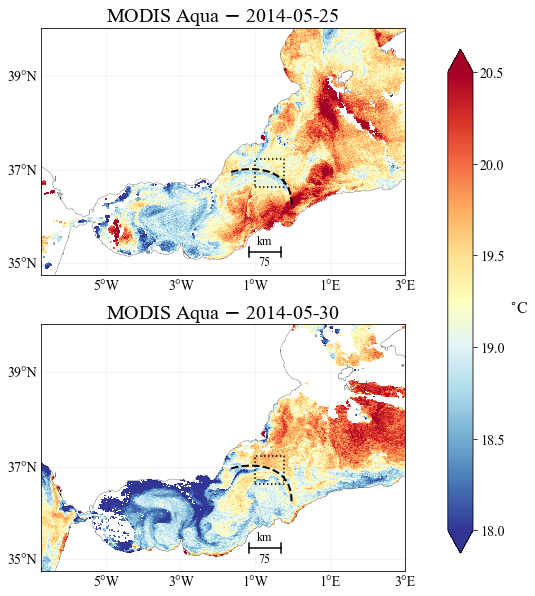

In [16]:
# Rectangle for the region of interest
xrect = (coordinates2[0], coordinates2[1], coordinates2[1], coordinates2[0], coordinates2[0])
yrect = (coordinates2[2], coordinates2[2], coordinates2[3], coordinates2[3], coordinates2[2])
    
figname = "fig02.png"
fig = plt.figure(figsize=(10, 10))

for ii, sstfile in enumerate(alborexpaths.sstfiles):
    logger.info("Working on file: {0}".format(os.path.basename(sstfile)))
    
    # Read data from file
    lon, lat, sst, sstqual, year, day, platform = alborexdata.load_sst_l2(sstfile)
    # Make the SST when flag > 1
    sst = np.ma.masked_where(sstqual > 1, sst)
    
    # Create date from year and day
    titledate = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(day) - 1)).strftime('%Y-%m-%d')
    figtitle = ' '.join(('MODIS', platform, '$-$', titledate))
    
    
    ax = plt.subplot(2,1,ii+1)
    m.ax = ax
    pcm = m.pcolormesh(lon, lat, sst, latlon=True, 
                       vmin=18., vmax=20.5, cmap=cmap)

    # Add the coastline
    for i in range(0, len(loncoast)):
        m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
               color='k', linewidth=.25, latlon=True)

    alborexdata.add_map_grid(m, coordinates1, dlon=2., dlat=2.,
                             fontname='Times New Roman', fontsize=14, 
                             linewidth=0.2, zorder=1, color=".6")

    m.drawmapscale(-.75, 35.25, -1, 35.25, 75, fontsize=12)

    m.plot(xrect, yrect, ":", color='k', latlon=True)

    xtext1, ytext1 = m(-3.2, 37.)
    xfig1, yfig1 = m(coordinates2[0], coordinates2[2])

    # Plot front
    m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
    ax.set_title(figtitle, fontsize=20)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.85, 0.15, 0.035, 0.7])
cb = plt.colorbar(pcm, cax=cbar_ax, extend='both')
cb.set_label('$^{\circ}$C', rotation=0, ha='left', fontsize=16)
cb.ax.tick_params(labelsize=14)

# plt.savefig(os.path.join(alborexpaths.figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Loop on the files

In [17]:
for sstfile in alborexpaths.sstfiles:
    logger.info("Working on file: {0}".format(os.path.basename(sstfile)))
    
    # Read data from file
    lon, lat, sst, sstqual, year, day, platform = alborexdata.load_sst_l2(sstfile)
    
    # Create date from year and day
    titledate = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(day) - 1)).strftime('%Y-%m-%d')
    figtitle = ' '.join(('MODIS', platform, '$-$', titledate))
    # logger.debug(title)
    
    # Make the SST when flag > 1
    sst = np.ma.masked_where(sstqual > 1, sst)

    # Create figure name (remove .nc extension and substitute . by _)
    figname = ''.join(('_'.join(os.path.basename(sstfile).split('.')[:-1]), '_cm.png'))
    logger.info("Making figure {0}".format(figname))
    
    # Rectangle for the region of interest
    xrect = (coordinates2[0], coordinates2[1], coordinates2[1], coordinates2[0], coordinates2[0])
    yrect = (coordinates2[2], coordinates2[2], coordinates2[3], coordinates2[3], coordinates2[2])
    
    if makeFigs:
        # Normal figures
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(111)
        m.ax = ax
        pcm = m.pcolormesh(lon, lat, sst, latlon=True, 
                           vmin=18., vmax=20.5, cmap=cmocean.cm.thermal)

        # Add the contours
        for i in range(0, len(loncoast)):
            m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
                   color='k', linewidth=.25, latlon=True)

        alborexdata.add_map_grid(m, coordinates1, dlon=2., dlat=2.,
                                 fontname='Times New Roman', fontsize=14, 
                                 linewidth=0.2, zorder=1, color=".6")

        #m.fillcontinents(color='w', zorder=2)
        #ax.set_xlim(coordinates[0], coordinates[1])
        #ax.set_ylim(coordinates[2], coordinates[3])

        cb = plt.colorbar(pcm, extend='both', shrink=0.6)
        cb.set_label('$^{\circ}$C', rotation=0, ha='left', fontsize=16)
        m.drawmapscale(-.75, 35.25, -1, 35.25, 75, fontsize=12)
        
        m.plot(xrect, yrect, ":", color='.25', latlon=True)

        xtext1, ytext1 = m(-3.2, 37.)
        xfig1, yfig1 = m(coordinates2[0], coordinates2[2])
        
        # Plot front
        m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
              
        plt.title(figtitle, fontsize=20)
        plt.savefig(os.path.join(alborexpaths.figdirleaflet, figname), dpi=300, bbox_inches='tight')
        plt.close()
        
    if makeFigsLeaflet:
    
        # Figures without border and axes
        llon, llat = m2(lon, lat)
        fig = plt.figure(frameon=False)
        ax = fig.add_axes([0, 0, 1, 1])
        m2.pcolormesh(llon, llat, sst, vmin=17., vmax=20., cmap=cmap)
        ax.axis('off')
        #ax.set_xlim(lon.min(), lon.max())
        #ax.set_ylim(lat.min(), lat.max())
        f1 = plt.gca()
        f1.axes.get_xaxis().set_ticks([])
        f1.axes.get_yaxis().set_ticks([])
        plt.savefig(os.path.join(alborexpaths.figdirleaflet, figname), transparent=True, 
                    bbox_inches='tight', pad_inches=0)
        plt.close()

2019-01-11 22:52:37,851 - alborex_logger - INFO - Working on file: A2014145125000.L2_LAC_SST.nc
2019-01-11 22:52:37,851 - alborex_logger - INFO - Working on file: A2014145125000.L2_LAC_SST.nc
2019-01-11 22:52:38,385 - alborex_logger - INFO - Making figure A2014145125000_L2_LAC_SST_cm.png
2019-01-11 22:52:38,385 - alborex_logger - INFO - Making figure A2014145125000_L2_LAC_SST_cm.png
2019-01-11 22:52:42,121 - alborex_logger - INFO - Working on file: A2014150020500.L2_LAC_SST.nc
2019-01-11 22:52:42,121 - alborex_logger - INFO - Working on file: A2014150020500.L2_LAC_SST.nc
2019-01-11 22:52:42,389 - alborex_logger - INFO - Making figure A2014150020500_L2_LAC_SST_cm.png
2019-01-11 22:52:42,389 - alborex_logger - INFO - Making figure A2014150020500_L2_LAC_SST_cm.png
